In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm
import random
from random import choice
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from kaggle_secrets import UserSecretsClient
from mpl_toolkits.axes_grid1 import ImageGrid
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision.models.vgg import vgg16
import sys
import torch.utils.data as data
import numpy as np
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import time
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim


# Enhance Image using Zero-DCE

"""
## The Zero-DCE Framework

The goal of DCE-Net is to estimate a set of best-fitting light-enhancement curves
(LE-curves) given an input image. The framework then maps all pixels of the input’s RGB
channels by applying the curves iteratively to obtain the final enhanced image.

### Understanding light-enhancement curves

A ligh-enhancement curve is a kind of curve that can map a low-light image
to its enhanced version automatically,
where the self-adaptive curve parameters are solely dependent on the input image.
When designing such a curve, three objectives should be taken into account:

- Each pixel value of the enhanced image should be in the normalized range `[0,1]`, in order to
avoid information loss induced by overflow truncation.
- It should be monotonous, to preserve the contrast between neighboring pixels.
- The shape of this curve should be as simple as possible,
and the curve should be differentiable to allow backpropagation.

The light-enhancement curve is separately applied to three RGB channels instead of solely on the
illumination channel. The three-channel adjustment can better preserve the inherent color and reduce
the risk of over-saturation.

![](https://li-chongyi.github.io/Zero-DCE_files/framework.png)

### DCE-Net

The DCE-Net is a lightweight deep neural network that learns the mapping between an input
image and its best-fitting curve parameter maps. The input to the DCE-Net is a low-light
image while the outputs are a set of pixel-wise curve parameter maps for corresponding
higher-order curves. It is a plain CNN of seven convolutional layers with symmetrical
concatenation. Each layer consists of 32 convolutional kernels of size 3×3 and stride 1
followed by the ReLU activation function. The last convolutional layer is followed by the
Tanh activation function, which produces 24 parameter maps for 8 iterations, where each
iteration requires three curve parameter maps for the three channels.

![](https://i.imgur.com/HtIg34W.png)
"""



In [2]:
def populate_train_list(lowlight_images_path):    
    # Danh sách tất cả các file trong thư mục
    all_files = os.listdir(lowlight_images_path)

    # Sử dụng glob để lấy tất cả file hình ảnh có đuôi .png, .jpg, hoặc .jpeg
    image_list_lowlight = glob.glob(os.path.join(lowlight_images_path, "*.png")) + \
                          glob.glob(os.path.join(lowlight_images_path, "*.jpg")) + \
                          glob.glob(os.path.join(lowlight_images_path, "*.jpeg"))

    
    valid_image_list = [img for img in image_list_lowlight if os.path.exists(img)]
    random.shuffle(valid_image_list)
    
    return valid_image_list

class lowlight_loader(data.Dataset):
    def __init__(self, lowlight_images_path):
        self.train_list = populate_train_list(lowlight_images_path) 
        self.size = 512  # Kích thước ảnh sẽ resize
        self.data_list = self.train_list
        print("Total training examples:", len(self.train_list))

    def __getitem__(self, index):
        data_lowlight_path = self.data_list[index]
        
        # Kiểm tra sự tồn tại của file trước khi mở
        if not os.path.exists(data_lowlight_path):
            print(f"Warning: File {data_lowlight_path} not found. Skipping this file.")
            return None  # Hoặc trả về một giá trị mặc định, chẳng hạn như một tensor rỗng

        try:
            # Đọc ảnh bằng OpenCV
            data_lowlight = cv2.imread(data_lowlight_path)
            if data_lowlight is None:
                raise ValueError(f"Error opening file {data_lowlight_path}: Unable to read image.")
        except Exception as e:
            print(f"Error opening file {data_lowlight_path}: {e}")
            return None  # Hoặc bỏ qua file có lỗi

        # Resize ảnh bằng OpenCV
        data_lowlight = cv2.resize(data_lowlight, (self.size, self.size), interpolation=cv2.INTER_LANCZOS4)
        
        # Chuẩn hóa dữ liệu (0-1)
        data_lowlight = data_lowlight.astype(np.float32) / 255.0
        
        # Chuyển ảnh sang tensor và chuyển đổi thứ tự kênh (HWC -> CHW)
        data_lowlight = torch.from_numpy(data_lowlight).float()
        
        if data_lowlight is None:
            print(f"Warning: Empty image at index {index}")
        
        # Chuyển từ [H, W, C] sang [C, H, W]
        return data_lowlight.permute(2, 0, 1)

    def __len__(self):
        return len(self.data_list)

In [3]:
class CSDN_Tem(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(CSDN_Tem, self).__init__()
        self.depth_conv = nn.Conv2d(
            in_channels=in_ch,
            out_channels=in_ch,
            kernel_size=3,
            stride=1,
            padding=1,
            groups=in_ch
        )
        self.point_conv = nn.Conv2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=1,
            stride=1,
            padding=0,
            groups=1
        )

    def forward(self, input):
        out = self.depth_conv(input)
        out = self.point_conv(out)
        return out

class enhance_net_nopool(nn.Module):
    def __init__(self,scale_factor):
        super(enhance_net_nopool, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.scale_factor = scale_factor
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=self.scale_factor)
        number_f = 32

#   zerodce DWC + p-shared
        self.e_conv1 = CSDN_Tem(3,number_f) 
        self.e_conv2 = CSDN_Tem(number_f,number_f) 
        self.e_conv3 = CSDN_Tem(number_f,number_f) 
        self.e_conv4 = CSDN_Tem(number_f,number_f) 
        self.e_conv5 = CSDN_Tem(number_f*2,number_f) 
        self.e_conv6 = CSDN_Tem(number_f*2,number_f) 
        self.e_conv7 = CSDN_Tem(number_f*2,3) 

    def enhance(self, x,x_r):

        x = x + x_r*(torch.pow(x,2)-x)
        x = x + x_r*(torch.pow(x,2)-x)
        x = x + x_r*(torch.pow(x,2)-x)
        enhance_image_1 = x + x_r*(torch.pow(x,2)-x)		
        x = enhance_image_1 + x_r*(torch.pow(enhance_image_1,2)-enhance_image_1)		
        x = x + x_r*(torch.pow(x,2)-x)	
        x = x + x_r*(torch.pow(x,2)-x)
        enhance_image = x + x_r*(torch.pow(x,2)-x)	

        return enhance_image
    def forward(self, x):
        if self.scale_factor==1:
            x_down = x
        else:
            x_down = F.interpolate(x,scale_factor=1/self.scale_factor, mode='bilinear')

        x1 = self.relu(self.e_conv1(x_down))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))
        x_r = F.tanh(self.e_conv7(torch.cat([x1,x6],1)))
        if self.scale_factor==1:
            x_r = x_r
        else:
            x_r = self.upsample(x_r)
        enhance_image = self.enhance(x,x_r)
        return enhance_image,x_r


## Loss functions

To enable zero-reference learning in DCE-Net, we use a set of differentiable
zero-reference losses that allow us to evaluate the quality of enhanced imag

"""
### Color constancy loss

The *color constancy loss* is used to correct the potential color deviations in the
enhan image.
"""

### Exposure loss

To restrain under-/over-exposed regions, we use the *exposure control loss*.
It measures the distance between the average intensity value of a local region
and a preset well-exposedness level (set to `0.6`).

### Illumination smoothness loss

To preserve the monotonicity relations between neighboring pixels, the
*illumination smoothness loss* is added to each curve parameter map.



### Spatial consistency loss

The *spatial consistency loss* encourages spatial coherence of the enhanced image by
preserving the contrast between neighboring regions across the input image and its enhanced version.


In [4]:
class L_color(nn.Module):
    def __init__(self):
        super(L_color, self).__init__()
    def forward(self, x ):
        b,c,h,w = x.shape
        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = torch.pow(mr-mg,2)
        Drb = torch.pow(mr-mb,2)
        Dgb = torch.pow(mb-mg,2)
        k = torch.pow(torch.pow(Drg,2) + torch.pow(Drb,2) + torch.pow(Dgb,2),0.5)
        return k

class L_spa(nn.Module):

    def __init__(self):
        super(L_spa, self).__init__()
        # print(1)kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
        kernel_left = torch.FloatTensor( [[0,0,0],[-1,1,0],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_right = torch.FloatTensor( [[0,0,0],[0,1,-1],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_up = torch.FloatTensor( [[0,-1,0],[0,1, 0 ],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_down = torch.FloatTensor( [[0,0,0],[0,1, 0],[0,-1,0]]).cuda().unsqueeze(0).unsqueeze(0)
        self.weight_left = nn.Parameter(data=kernel_left, requires_grad=False)
        self.weight_right = nn.Parameter(data=kernel_right, requires_grad=False)
        self.weight_up = nn.Parameter(data=kernel_up, requires_grad=False)
        self.weight_down = nn.Parameter(data=kernel_down, requires_grad=False)
        self.pool = nn.AvgPool2d(4)
    def forward(self, org , enhance ):
        b,c,h,w = org.shape

        org_mean = torch.mean(org,1,keepdim=True)
        enhance_mean = torch.mean(enhance,1,keepdim=True)

        org_pool =  self.pool(org_mean)			
        enhance_pool = self.pool(enhance_mean)	

        weight_diff =torch.max(torch.FloatTensor([1]).cuda() + 10000*torch.min(org_pool - torch.FloatTensor([0.3]).cuda(),torch.FloatTensor([0]).cuda()),torch.FloatTensor([0.5]).cuda())
        E_1 = torch.mul(torch.sign(enhance_pool - torch.FloatTensor([0.5]).cuda()) ,enhance_pool-org_pool)


        D_org_letf = F.conv2d(org_pool , self.weight_left, padding=1)
        D_org_right = F.conv2d(org_pool , self.weight_right, padding=1)
        D_org_up = F.conv2d(org_pool , self.weight_up, padding=1)
        D_org_down = F.conv2d(org_pool , self.weight_down, padding=1)

        D_enhance_letf = F.conv2d(enhance_pool , self.weight_left, padding=1)
        D_enhance_right = F.conv2d(enhance_pool , self.weight_right, padding=1)
        D_enhance_up = F.conv2d(enhance_pool , self.weight_up, padding=1)
        D_enhance_down = F.conv2d(enhance_pool , self.weight_down, padding=1)

        D_left = torch.pow(D_org_letf - D_enhance_letf,2)
        D_right = torch.pow(D_org_right - D_enhance_right,2)
        D_up = torch.pow(D_org_up - D_enhance_up,2)
        D_down = torch.pow(D_org_down - D_enhance_down,2)
        E = (D_left + D_right + D_up +D_down)
        # E = 25*(D_left + D_right + D_up +D_down)

        return E
class L_exp(nn.Module):

    def __init__(self,patch_size):
        super(L_exp, self).__init__()
        # print(1)
        self.pool = nn.AvgPool2d(patch_size)
        # self.mean_val = mean_val
    def forward(self, x, mean_val ):

        b,c,h,w = x.shape
        x = torch.mean(x,1,keepdim=True)
        mean = self.pool(x)

        d = torch.mean(torch.pow(mean- torch.FloatTensor([mean_val] ).cuda(),2))
        return d
        
class L_TV(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(L_TV,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h =  (x.size()[2]-1) * x.size()[3]
        count_w = x.size()[2] * (x.size()[3] - 1)
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size
class Sa_Loss(nn.Module):
    def __init__(self):
        super(Sa_Loss, self).__init__()
        # print(1)
    def forward(self, x ):
        # self.grad = np.ones(x.shape,dtype=np.float32)
        b,c,h,w = x.shape
        # x_de = x.cpu().detach().numpy()
        r,g,b = torch.split(x , 1, dim=1)
        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Dr = r-mr
        Dg = g-mg
        Db = b-mb
        k =torch.pow( torch.pow(Dr,2) + torch.pow(Db,2) + torch.pow(Dg,2),0.5)
        # print(k)
        

        k = torch.mean(k)
        return k

class perception_loss(nn.Module):
    def __init__(self):
        super(perception_loss, self).__init__()
        # vgg = vgg16(pretrained=True).cuda()
        features = vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential() 
        self.to_relu_2_2 = nn.Sequential() 
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), features[x])
        
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        h_relu_3_3 = h
        h = self.to_relu_4_3(h)
        h_relu_4_3 = h
        # out = (h_relu_1_2, h_relu_2_2, h_relu_3_3, h_relu_4_3)
        return h_relu_4_3

In [5]:
L_color = L_color()
L_spa = L_spa()
L_exp = L_exp(16)
# L_exp = Myloss.L_exp(16,0.6)
L_TV = L_TV()

from tqdm import tqdm
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [6]:
from tqdm import tqdm

# Define the training function with result tracking for plotting and validation
def train(config):
    scale_factor = config.scale_factor
    DCE_net = enhance_net_nopool(scale_factor).cuda()

    # Initialize weights if required
    # DCE_net.apply(weights_init)
    
    # Load pretrained model if specified
    if config.load_pretrain:
        DCE_net.load_state_dict(torch.load(config.pretrain_dir))
    
    # Prepare training and validation datasets and dataloaders
    train_dataset = lowlight_loader(config.lowlight_images_path)
    val_dataset = lowlight_loader(config.val_images_path)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.val_batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)

    optimizer = torch.optim.Adam(DCE_net.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    DCE_net.train()

    # Dictionary to store loss history for plotting
    loss_history = {
        "total_loss": [],
        "illumination_smoothness_loss": [],
        "spatial_constancy_loss": [],
        "color_constancy_loss": [],
        "exposure_loss": [],
        "val_total_loss": [],
        "val_illumination_smoothness_loss": [],
        "val_spatial_constancy_loss": [],
        "val_color_constancy_loss": [],
        "val_exposure_loss": []
    }

    # Training loop
    for epoch in range(config.num_epochs):
        print(f"Epoch {epoch + 1}/{config.num_epochs}")
        
        # Initialize loss accumulators for training
        epoch_loss = 0
        illumination_smoothness_loss = 0
        spatial_constancy_loss = 0
        color_constancy_loss = 0
        exposure_loss = 0

        # Training phase
        DCE_net.train()
        train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
        
        for iteration, img_lowlight in enumerate(train_loader_tqdm):
            img_lowlight = img_lowlight.cuda()
            E = 0.5

            # Forward pass through DCE_net
            enhanced_image, A = DCE_net(img_lowlight)
            
            # Calculate individual losses
            Loss_TV = 1600 * L_TV(A)
            loss_spa = torch.mean(L_spa(enhanced_image, img_lowlight))
            loss_col = 5 * torch.mean(L_color(enhanced_image))
            loss_exp = 10 * torch.mean(L_exp(enhanced_image, E))

            # Calculate total loss
            loss = Loss_TV + loss_spa + loss_col + loss_exp
            epoch_loss += loss.item()
            illumination_smoothness_loss += Loss_TV.item()
            spatial_constancy_loss += loss_spa.item()
            color_constancy_loss += loss_col.item()
            exposure_loss += loss_exp.item()

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(DCE_net.parameters(), config.grad_clip_norm)
            optimizer.step()

            # Update tqdm progress bar with current loss
            train_loader_tqdm.set_postfix({"loss": loss.item()})

            # Save model snapshot at specified intervals
            if (iteration + 1) % config.snapshot_iter == 0:
                torch.save(DCE_net.state_dict(), os.path.join(config.snapshots_folder, f"Epoch{epoch}.pth"))

        # Calculate average loss for each component on training set
        avg_total_loss = epoch_loss / len(train_loader)
        avg_illumination_loss = illumination_smoothness_loss / len(train_loader)
        avg_spatial_loss = spatial_constancy_loss / len(train_loader)
        avg_color_loss = color_constancy_loss / len(train_loader)
        avg_exposure_loss = exposure_loss / len(train_loader)

        # Append average training losses for each epoch
        loss_history["total_loss"].append(avg_total_loss)
        loss_history["illumination_smoothness_loss"].append(avg_illumination_loss)
        loss_history["spatial_constancy_loss"].append(avg_spatial_loss)
        loss_history["color_constancy_loss"].append(avg_color_loss)
        loss_history["exposure_loss"].append(avg_exposure_loss)

        # Validation phase
        DCE_net.eval()
        val_epoch_loss = 0
        val_illumination_smoothness_loss = 0
        val_spatial_constancy_loss = 0
        val_color_constancy_loss = 0
        val_exposure_loss = 0

        with torch.no_grad():
            for img_lowlight in tqdm(val_loader, desc="Validating", leave=False):
                img_lowlight = img_lowlight.cuda()

                # Forward pass
                enhanced_image, A = DCE_net(img_lowlight)

                # Calculate validation losses
                val_Loss_TV = 1600 * L_TV(A)
                val_loss_spa = torch.mean(L_spa(enhanced_image, img_lowlight))
                val_loss_col = 5 * torch.mean(L_color(enhanced_image))
                val_loss_exp = 10 * torch.mean(L_exp(enhanced_image, E))

                val_loss = val_Loss_TV + val_loss_spa + val_loss_col + val_loss_exp
                val_epoch_loss += val_loss.item()
                val_illumination_smoothness_loss += val_Loss_TV.item()
                val_spatial_constancy_loss += val_loss_spa.item()
                val_color_constancy_loss += val_loss_col.item()
                val_exposure_loss += val_loss_exp.item()

        # Calculate average validation losses for each component
        avg_val_total_loss = val_epoch_loss / len(val_loader)
        avg_val_illumination_loss = val_illumination_smoothness_loss / len(val_loader)
        avg_val_spatial_loss = val_spatial_constancy_loss / len(val_loader)
        avg_val_color_loss = val_color_constancy_loss / len(val_loader)
        avg_val_exposure_loss = val_exposure_loss / len(val_loader)

        # Append average validation losses for each epoch
        loss_history["val_total_loss"].append(avg_val_total_loss)
        loss_history["val_illumination_smoothness_loss"].append(avg_val_illumination_loss)
        loss_history["val_spatial_constancy_loss"].append(avg_val_spatial_loss)
        loss_history["val_color_constancy_loss"].append(avg_val_color_loss)
        loss_history["val_exposure_loss"].append(avg_val_exposure_loss)

        # Print average loss for each epoch
        print(f"Epoch {epoch + 1} - Avg Total Loss: {avg_total_loss:.4f}, Val Total Loss: {avg_val_total_loss:.4f}")

    return loss_history

# Plot function for training and validation history
def plot_result(loss_history, loss_type):
    plt.plot(loss_history[loss_type], label="Train " + loss_type)
    plt.plot(loss_history["val_" + loss_type], label="Val " + loss_type)
    plt.xlabel("Epochs")
    plt.ylabel(loss_type)
    plt.title(f"Train and Validation {loss_type} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


Total training examples: 1944
Total training examples: 542
Epoch 1/100


Epoch 1 - Avg Total Loss: 1.2323, Val Total Loss: 1.0812
Epoch 2/100


Epoch 2 - Avg Total Loss: 1.1217, Val Total Loss: 1.0804
Epoch 3/100


Epoch 3 - Avg Total Loss: 1.1111, Val Total Loss: 1.0706
Epoch 4/100


Epoch 4 - Avg Total Loss: 1.1061, Val Total Loss: 1.0816
Epoch 5/100


Epoch 5 - Avg Total Loss: 1.0994, Val Total Loss: 1.0597
Epoch 6/100


Epoch 6 - Avg Total Loss: 1.0935, Val Total Loss: 1.0542
Epoch 7/100


Epoch 7 - Avg Total Loss: 1.0879, Val Total Loss: 1.0541
Epoch 8/100


Epoch 8 - Avg Total Loss: 1.0871, Val Total Loss: 1.0488
Epoch 9/100


Epoch 9 - Avg Total Loss: 1.0807, Val Total Loss: 1.0448
Epoch 10/100


Epoch 10 - Avg Total Loss: 1.0776, Val Total Loss: 1.0428
Epoch 11/100


Epoch 11 - Avg Total Loss: 1.0784, Val Total Loss: 1.0442
Epoch 12/100


Epoch 12 - Avg Total Loss: 1.0726, Val Total Loss: 1.0381
Epoch 13/100


Epoch 13 - Avg Total Loss: 1.0725, Val Total Loss: 1.0489
Epoch 14/100


Epoch 14 - Avg Total Loss: 1.0709, Val Total Loss: 1.0365
Epoch 15/100


Epoch 15 - Avg Total Loss: 1.0694, Val Total Loss: 1.0388
Epoch 16/100


Epoch 16 - Avg Total Loss: 1.0699, Val Total Loss: 1.0383
Epoch 17/100


Epoch 17 - Avg Total Loss: 1.0706, Val Total Loss: 1.0369
Epoch 18/100


Epoch 18 - Avg Total Loss: 1.0682, Val Total Loss: 1.0333
Epoch 19/100


Epoch 19 - Avg Total Loss: 1.0704, Val Total Loss: 1.0369
Epoch 20/100


Epoch 20 - Avg Total Loss: 1.0712, Val Total Loss: 1.0326
Epoch 21/100


Epoch 21 - Avg Total Loss: 1.0670, Val Total Loss: 1.0447
Epoch 22/100


Epoch 22 - Avg Total Loss: 1.0669, Val Total Loss: 1.0331
Epoch 23/100


Epoch 23 - Avg Total Loss: 1.0636, Val Total Loss: 1.0321
Epoch 24/100


Epoch 24 - Avg Total Loss: 1.0580, Val Total Loss: 1.0253
Epoch 25/100


Epoch 25 - Avg Total Loss: 1.0558, Val Total Loss: 1.0235
Epoch 26/100


Epoch 26 - Avg Total Loss: 1.0533, Val Total Loss: 1.0223
Epoch 27/100


Epoch 27 - Avg Total Loss: 1.0538, Val Total Loss: 1.0220
Epoch 28/100


Epoch 28 - Avg Total Loss: 1.0533, Val Total Loss: 1.0329
Epoch 29/100


Epoch 29 - Avg Total Loss: 1.0519, Val Total Loss: 1.0237
Epoch 30/100


Epoch 30 - Avg Total Loss: 1.0499, Val Total Loss: 1.0360
Epoch 31/100


Epoch 31 - Avg Total Loss: 1.0458, Val Total Loss: 1.0170
Epoch 32/100


Epoch 32 - Avg Total Loss: 1.0433, Val Total Loss: 1.0170
Epoch 33/100


Epoch 33 - Avg Total Loss: 1.0466, Val Total Loss: 1.0223
Epoch 34/100


Epoch 34 - Avg Total Loss: 1.0473, Val Total Loss: 1.0163
Epoch 35/100


Epoch 35 - Avg Total Loss: 1.0446, Val Total Loss: 1.0187
Epoch 36/100


Epoch 36 - Avg Total Loss: 1.0443, Val Total Loss: 1.0144
Epoch 37/100


Epoch 37 - Avg Total Loss: 1.0447, Val Total Loss: 1.0245
Epoch 38/100


Epoch 38 - Avg Total Loss: 1.0428, Val Total Loss: 1.0132
Epoch 39/100


Epoch 39 - Avg Total Loss: 1.0429, Val Total Loss: 1.0140
Epoch 40/100


Epoch 40 - Avg Total Loss: 1.0412, Val Total Loss: 1.0138
Epoch 41/100


Epoch 41 - Avg Total Loss: 1.0413, Val Total Loss: 1.0312
Epoch 42/100


Epoch 42 - Avg Total Loss: 1.0422, Val Total Loss: 1.0143
Epoch 43/100


Epoch 43 - Avg Total Loss: 1.0416, Val Total Loss: 1.0132
Epoch 44/100


Epoch 44 - Avg Total Loss: 1.0415, Val Total Loss: 1.0116
Epoch 45/100


Epoch 45 - Avg Total Loss: 1.0420, Val Total Loss: 1.0157
Epoch 46/100


Epoch 46 - Avg Total Loss: 1.0398, Val Total Loss: 1.0118
Epoch 47/100


Epoch 47 - Avg Total Loss: 1.0379, Val Total Loss: 1.0135
Epoch 48/100


Epoch 48 - Avg Total Loss: 1.0390, Val Total Loss: 1.0123
Epoch 49/100


Epoch 49 - Avg Total Loss: 1.0384, Val Total Loss: 1.0135
Epoch 50/100


Epoch 50 - Avg Total Loss: 1.0395, Val Total Loss: 1.0129
Epoch 51/100


Epoch 51 - Avg Total Loss: 1.0391, Val Total Loss: 1.0144
Epoch 52/100


Epoch 52 - Avg Total Loss: 1.0368, Val Total Loss: 1.0098
Epoch 53/100


Epoch 53 - Avg Total Loss: 1.0376, Val Total Loss: 1.0132
Epoch 54/100


Epoch 54 - Avg Total Loss: 1.0370, Val Total Loss: 1.0120
Epoch 55/100


Epoch 55 - Avg Total Loss: 1.0381, Val Total Loss: 1.0156
Epoch 56/100


Epoch 56 - Avg Total Loss: 1.0386, Val Total Loss: 1.0154
Epoch 57/100


Epoch 57 - Avg Total Loss: 1.0384, Val Total Loss: 1.0121
Epoch 58/100


Epoch 58 - Avg Total Loss: 1.0353, Val Total Loss: 1.0095
Epoch 59/100


Epoch 59 - Avg Total Loss: 1.0355, Val Total Loss: 1.0109
Epoch 60/100


Epoch 60 - Avg Total Loss: 1.0364, Val Total Loss: 1.0106
Epoch 61/100


Epoch 61 - Avg Total Loss: 1.0365, Val Total Loss: 1.0078
Epoch 62/100


Epoch 62 - Avg Total Loss: 1.0350, Val Total Loss: 1.0146
Epoch 63/100


Epoch 63 - Avg Total Loss: 1.0359, Val Total Loss: 1.0069
Epoch 64/100


Epoch 64 - Avg Total Loss: 1.0342, Val Total Loss: 1.0095
Epoch 65/100


Epoch 65 - Avg Total Loss: 1.0357, Val Total Loss: 1.0085
Epoch 66/100


Epoch 66 - Avg Total Loss: 1.0357, Val Total Loss: 1.0106
Epoch 67/100


Epoch 67 - Avg Total Loss: 1.0363, Val Total Loss: 1.0176
Epoch 68/100


Epoch 68 - Avg Total Loss: 1.0349, Val Total Loss: 1.0075
Epoch 69/100


Epoch 69 - Avg Total Loss: 1.0354, Val Total Loss: 1.0133
Epoch 70/100


Epoch 70 - Avg Total Loss: 1.0331, Val Total Loss: 1.0091
Epoch 71/100


Epoch 71 - Avg Total Loss: 1.0341, Val Total Loss: 1.0093
Epoch 72/100


Epoch 72 - Avg Total Loss: 1.0329, Val Total Loss: 1.0089
Epoch 73/100


Epoch 73 - Avg Total Loss: 1.0338, Val Total Loss: 1.0082
Epoch 74/100


Epoch 74 - Avg Total Loss: 1.0347, Val Total Loss: 1.0057
Epoch 75/100


Epoch 75 - Avg Total Loss: 1.0324, Val Total Loss: 1.0076
Epoch 76/100


Epoch 76 - Avg Total Loss: 1.0329, Val Total Loss: 1.0094
Epoch 77/100


Epoch 77 - Avg Total Loss: 1.0317, Val Total Loss: 1.0069
Epoch 78/100


Epoch 78 - Avg Total Loss: 1.0318, Val Total Loss: 1.0059
Epoch 79/100


Epoch 79 - Avg Total Loss: 1.0322, Val Total Loss: 1.0085
Epoch 80/100


Epoch 80 - Avg Total Loss: 1.0334, Val Total Loss: 1.0085
Epoch 81/100


Epoch 81 - Avg Total Loss: 1.0326, Val Total Loss: 1.0139
Epoch 82/100


Epoch 82 - Avg Total Loss: 1.0325, Val Total Loss: 1.0063
Epoch 83/100


Epoch 83 - Avg Total Loss: 1.0343, Val Total Loss: 1.0062
Epoch 84/100


Epoch 84 - Avg Total Loss: 1.0330, Val Total Loss: 1.0057
Epoch 85/100


Epoch 85 - Avg Total Loss: 1.0332, Val Total Loss: 1.0057
Epoch 86/100


Epoch 86 - Avg Total Loss: 1.0310, Val Total Loss: 1.0047
Epoch 87/100


Epoch 87 - Avg Total Loss: 1.0316, Val Total Loss: 1.0077
Epoch 88/100


Epoch 88 - Avg Total Loss: 1.0335, Val Total Loss: 1.0062
Epoch 89/100


Epoch 89 - Avg Total Loss: 1.0320, Val Total Loss: 1.0106
Epoch 90/100


Epoch 90 - Avg Total Loss: 1.0315, Val Total Loss: 1.0087
Epoch 91/100


Epoch 91 - Avg Total Loss: 1.0322, Val Total Loss: 1.0056
Epoch 92/100


Epoch 92 - Avg Total Loss: 1.0312, Val Total Loss: 1.0060
Epoch 93/100


Epoch 93 - Avg Total Loss: 1.0310, Val Total Loss: 1.0139
Epoch 94/100


Epoch 94 - Avg Total Loss: 1.0318, Val Total Loss: 1.0077
Epoch 95/100


Epoch 95 - Avg Total Loss: 1.0319, Val Total Loss: 1.0049
Epoch 96/100


Epoch 96 - Avg Total Loss: 1.0345, Val Total Loss: 1.0084
Epoch 97/100


Epoch 97 - Avg Total Loss: 1.0317, Val Total Loss: 1.0079
Epoch 98/100


Epoch 98 - Avg Total Loss: 1.0329, Val Total Loss: 1.0070
Epoch 99/100


Epoch 99 - Avg Total Loss: 1.0329, Val Total Loss: 1.0095
Epoch 100/100


Epoch 100 - Avg Total Loss: 1.0317, Val Total Loss: 1.0057


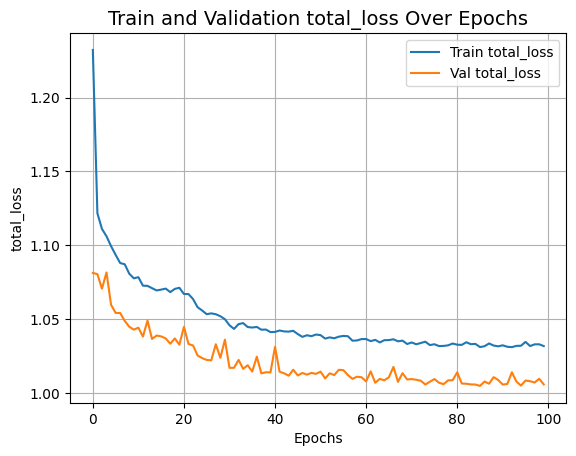

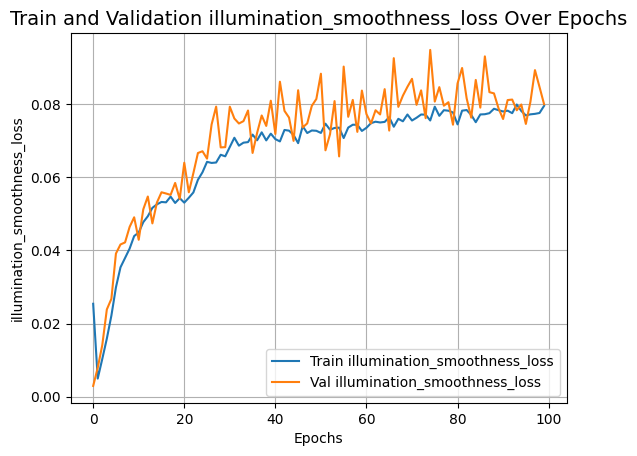

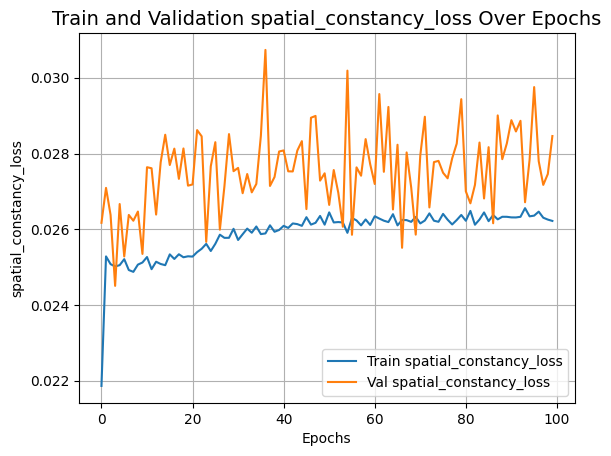

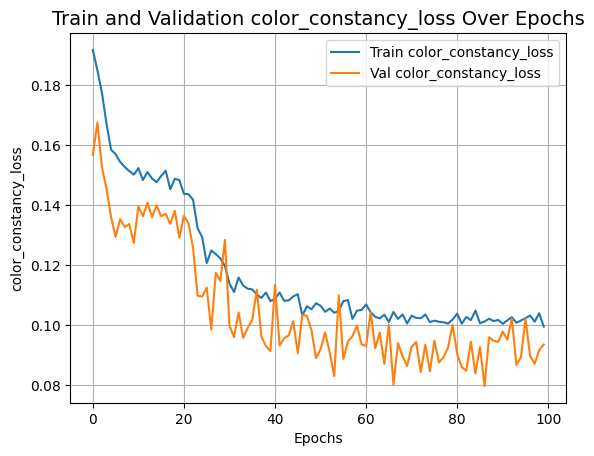

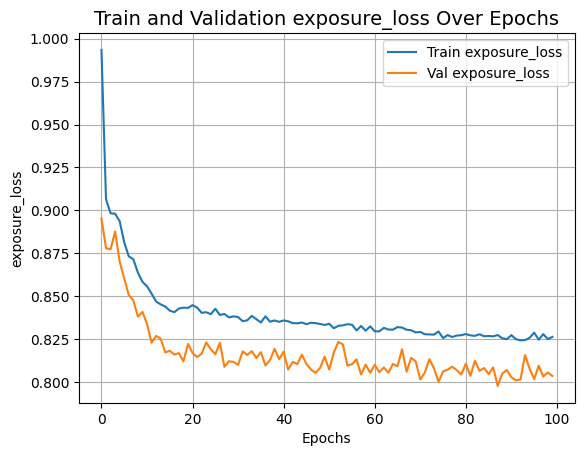

In [7]:
class Config:
    # Đường dẫn tới tập huấn luyện và tập validation
    lowlight_images_path = "/kaggle/input/cs406-data/Dark_Dataset/Dark_Dataset/train/images"
    val_images_path = "/kaggle/input/cs406-data/Dark_Dataset/Dark_Dataset/val/images"
    
    # Các tham số huấn luyện
    lr = 0.001
    weight_decay = 0.0001
    grad_clip_norm = 1.0
    num_epochs = 100
    train_batch_size = 16
    val_batch_size = 16
    num_workers = 4
    display_iter = 10
    snapshot_iter = 10
    scale_factor = 1
    
    # Đường dẫn thư mục lưu checkpoints và pretrained model
    snapshots_folder = "snapshots_Zero_DCE++/"
    load_pretrain = False
    pretrain_dir = "snapshots_Zero_DCE++/Epoch99.pth"

# Tạo đối tượng config
config = Config()

# Tạo thư mục snapshots nếu chưa tồn tại
if not os.path.exists(config.snapshots_folder):
    os.mkdir(config.snapshots_folder)

loss_history = train(config)

# Plot each loss component
plot_result(loss_history, "total_loss")
plot_result(loss_history, "illumination_smoothness_loss")
plot_result(loss_history, "spatial_constancy_loss")
plot_result(loss_history, "color_constancy_loss")
plot_result(loss_history, "exposure_loss")


## Inference

<ipython-input-8-8e4f7ef1101f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Original Image Shape: (640, 640, 3)
Enhanced Image Shape: (640, 640, 3)


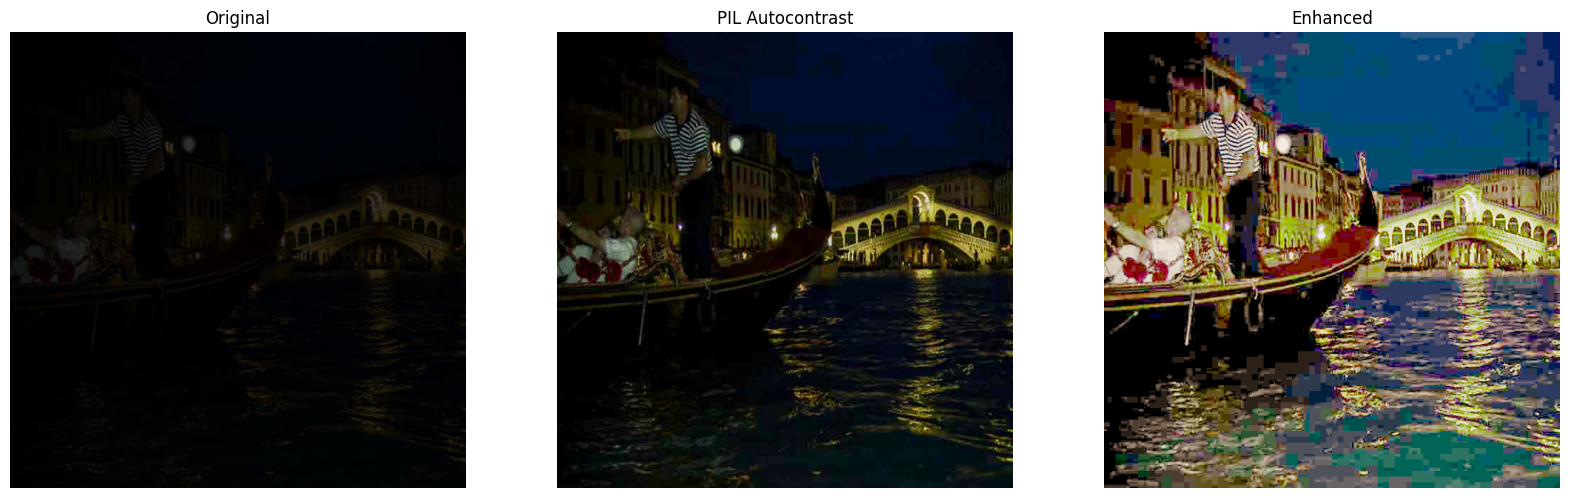

Original Image Shape: (640, 640, 3)
Enhanced Image Shape: (640, 640, 3)


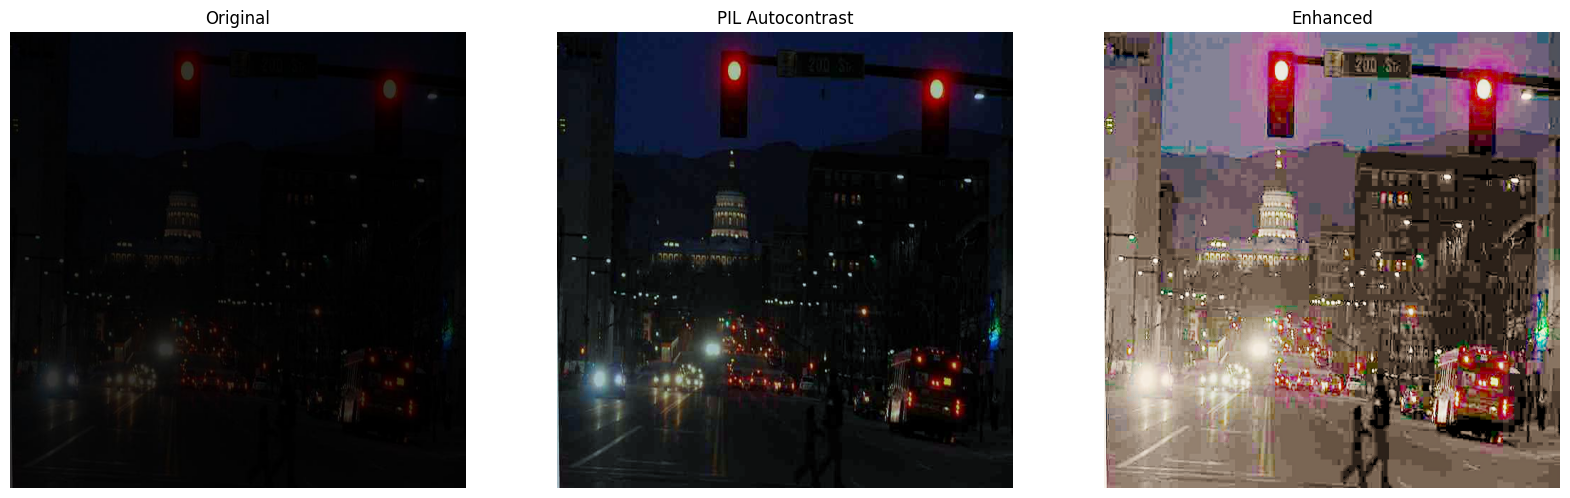

Original Image Shape: (640, 640, 3)
Enhanced Image Shape: (640, 640, 3)


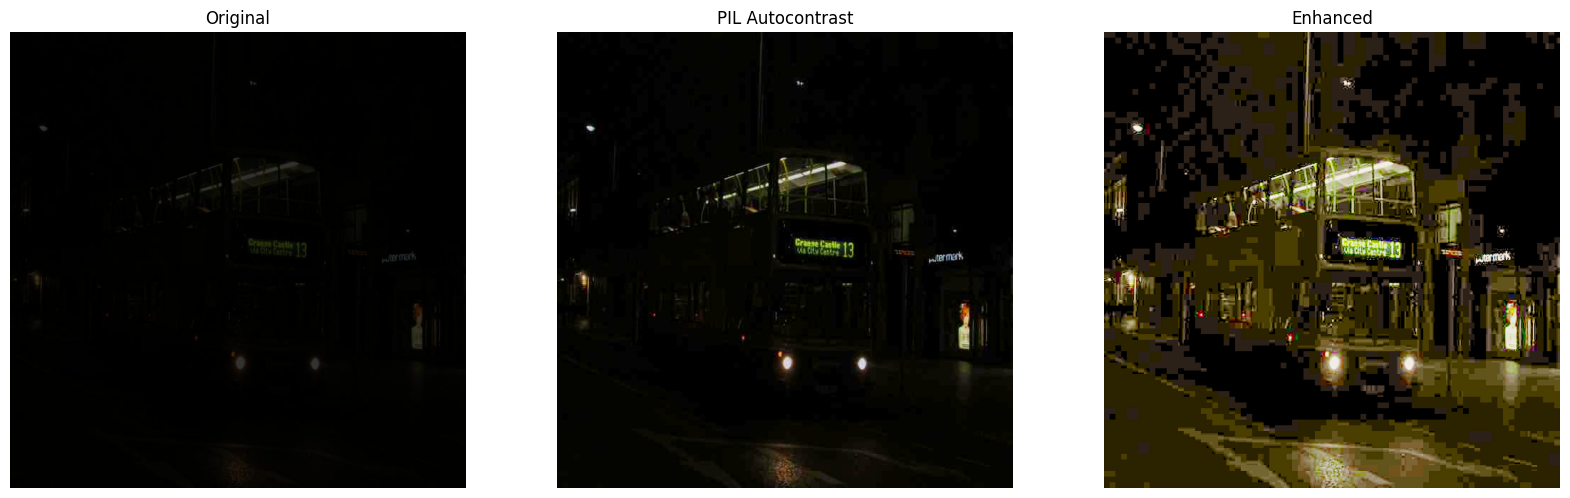

Original Image Shape: (640, 640, 3)
Enhanced Image Shape: (640, 640, 3)


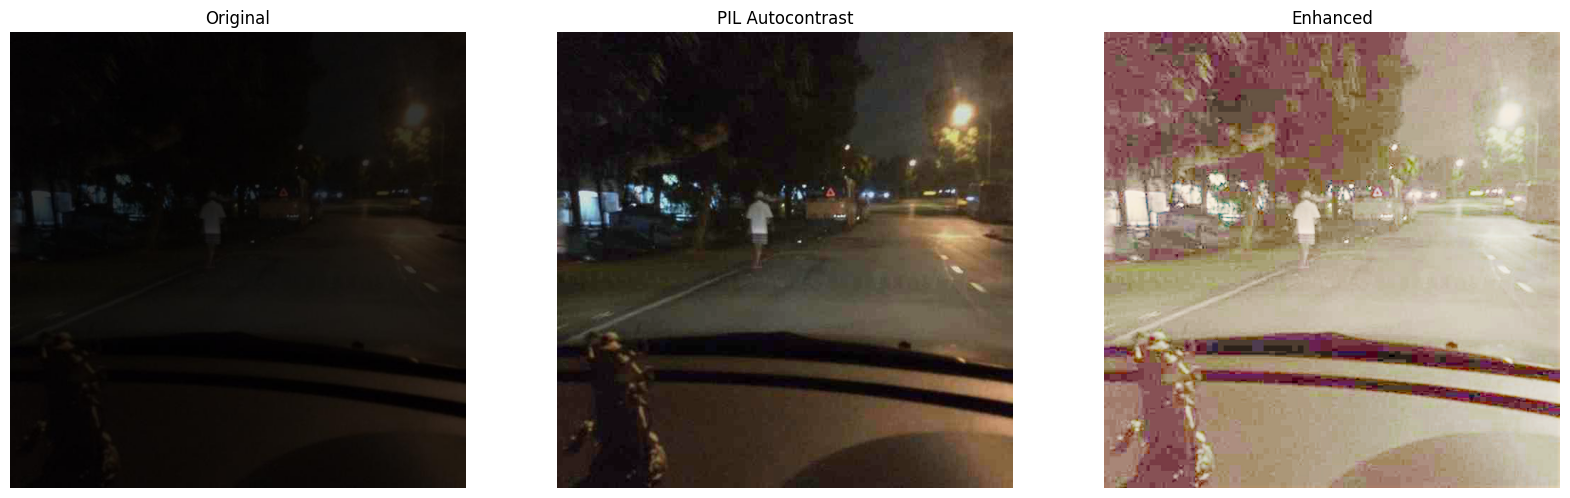

Original Image Shape: (640, 640, 3)
Enhanced Image Shape: (640, 640, 3)


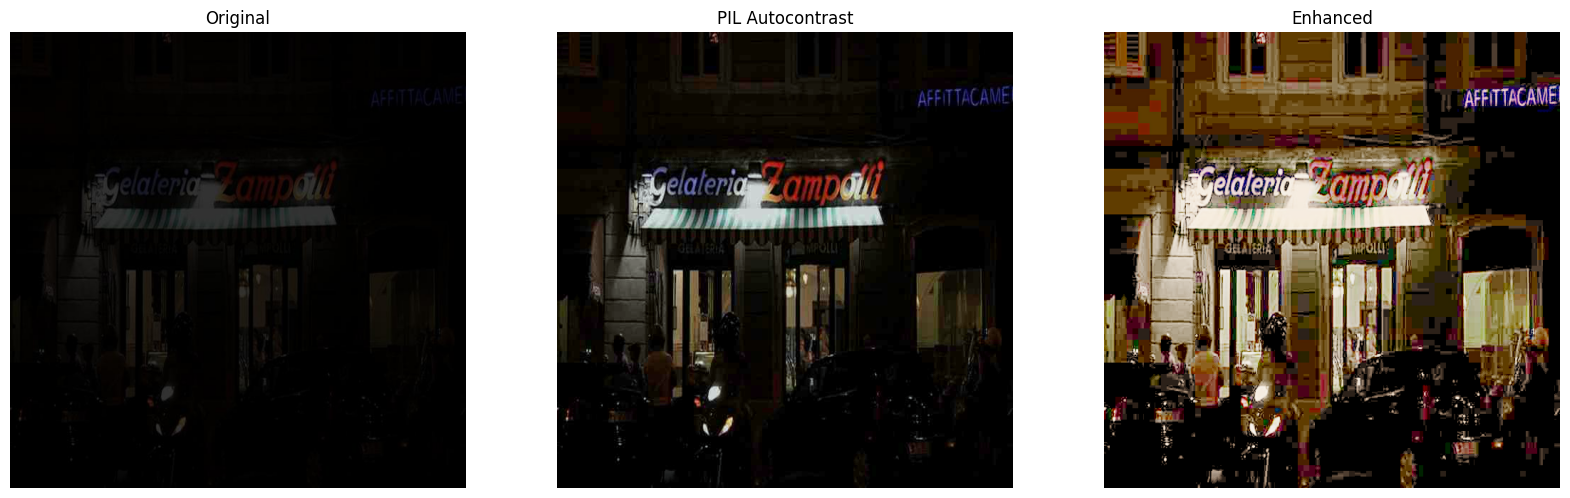

In [8]:
# Function to load a model checkpoint
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    model.eval()  # Set to evaluation mode
    return model

# Define the inference function
def resize_image_and_labels(image, label_path, target_size=(640, 640)):
    """
    Resize image and adjust YOLO labels accordingly.
    Args:
        image (PIL.Image): Original image.
        label_path (str): Path to the label file.
        target_size (tuple): Target size (width, height).
    Returns:
        PIL.Image: Resized image.
        list: Updated labels.
    """
    original_width, original_height = image.size
    resized_image = image.resize(target_size, Image.Resampling.LANCZOS)  # Updated to use LANCZOS
    
    updated_labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as label_file:
            lines = label_file.readlines()
            for line in lines:
                if line.strip().startswith('bbGt'):  # Skip lines starting with 'bbGt'
                    continue
                
                parts = line.strip().split()
                if len(parts) < 5:  # Ensure the line has enough parts for YOLO format
                    continue
                
                try:
                    class_id = parts[0]
                    x_center = float(parts[1]) * original_width / target_size[0]
                    y_center = float(parts[2]) * original_height / target_size[1]
                    width = float(parts[3]) * original_width / target_size[0]
                    height = float(parts[4]) * original_height / target_size[1]
                    updated_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
                except ValueError:
                    print(f"Skipping invalid label line: {line.strip()}")
                    continue
    return resized_image, updated_labels

# Define the inference function with additional formatting for saving
def infer(original_image, model, label_path, target_size=(640, 640)):
    """
    Enhance the image using the given model with resizing and adjust labels.
    Args:
        original_image (PIL.Image): The original image.
        model (torch.nn.Module): The enhancement model.
        label_path (str): Path to the label file.
        target_size (tuple): Target size for resizing (width, height).
    Returns:
        np.ndarray: Enhanced image in numpy format.
        list: Updated labels.
    """
    # Resize the image and labels
    resized_image, updated_labels = resize_image_and_labels(original_image, label_path, target_size)

    # Preprocess the image: convert to tensor and normalize
    preprocess = transforms.ToTensor()
    img_tensor = preprocess(resized_image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

    # Run the model
    with torch.no_grad():
        enhanced_image, _ = model(img_tensor)  # Only use the enhanced image output
        enhanced_image = enhanced_image.squeeze(0)  # Remove batch dimension

    # Convert the enhanced image back to numpy format
    enhanced_image_np = enhanced_image.permute(1, 2, 0).cpu().numpy()  # Convert from CHW to HWC
    enhanced_image_np = np.clip(enhanced_image_np * 255, 0, 255).astype(np.uint8)  # Ensure uint8 format for saving
    return enhanced_image_np, updated_labels

# Function to plot results
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

# Load the model with the specified checkpoint
scale_factor = config.scale_factor
DCE_net = enhance_net_nopool(scale_factor).cuda()
DCE_net = load_checkpoint(DCE_net, config.pretrain_dir)

# Perform inference and plotting on test images
test_image_dir = '/kaggle/input/cs406-data/Dark_Dataset/Dark_Dataset/test'

for image_file in os.listdir(os.path.join(test_image_dir, 'images'))[:5]:
    original_image = Image.open(os.path.join(test_image_dir, 'images', image_file)).convert('RGB')
    
    # Print shape of the original image as a numpy array
    original_image_np = np.array(original_image)
    print("Original Image Shape:", original_image_np.shape)
    
    # Label path
    label_path = os.path.join(test_image_dir, 'labels', os.path.splitext(image_file)[0] + '.txt')
    
    # Inference
    enhanced_image_np, updated_labels = infer(original_image, DCE_net, label_path, target_size=(640, 640))
    
    # Convert enhanced image back to PIL format for plotting
    enhanced_image = Image.fromarray(enhanced_image_np)
    
    # Print shape of the enhanced image
    print("Enhanced Image Shape:", enhanced_image_np.shape)
    
    # Display the results
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "Enhanced"],
        (20, 12),
    )


In [9]:
import xml.etree.ElementTree as ET
from xml.dom import minidom
from PIL import Image
import os
import shutil
import torch
import numpy as np
from torchvision import transforms

# Function to create VOC XML annotation
def create_voc_annotation(image_path, updated_labels, output_voc_dir):
    """
    Create a VOC annotation file in XML format.
    Args:
        image_path (str): Path to the image file.
        updated_labels (list): List of updated labels in YOLO format.
        output_voc_dir (str): Directory to save the XML annotation.
    """
    image = Image.open(image_path)
    width, height = image.size

    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "folder").text = os.path.basename(os.path.dirname(image_path))
    ET.SubElement(annotation, "filename").text = os.path.basename(image_path)
    ET.SubElement(annotation, "path").text = image_path

    source = ET.SubElement(annotation, "source")
    ET.SubElement(source, "database").text = "Unknown"

    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"

    ET.SubElement(annotation, "segmented").text = "0"

    for label in updated_labels:
        parts = label.split()
        class_id = parts[0]
        x_center = float(parts[1])
        y_center = float(parts[2])
        bbox_width = float(parts[3])
        bbox_height = float(parts[4])

        xmin = int((x_center - bbox_width / 2) * width)
        ymin = int((y_center - bbox_height / 2) * height)
        xmax = int((x_center + bbox_width / 2) * width)
        ymax = int((y_center + bbox_height / 2) * height)

        obj = ET.SubElement(annotation, "object")
        ET.SubElement(obj, "name").text = class_id  # Replace with class name mapping if needed
        ET.SubElement(obj, "pose").text = "Unspecified"
        ET.SubElement(obj, "truncated").text = "0"
        ET.SubElement(obj, "difficult").text = "0"

        bndbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(max(0, xmin))
        ET.SubElement(bndbox, "ymin").text = str(max(0, ymin))
        ET.SubElement(bndbox, "xmax").text = str(min(width, xmax))
        ET.SubElement(bndbox, "ymax").text = str(min(height, ymax))

    # Save as pretty XML
    xml_str = minidom.parseString(ET.tostring(annotation)).toprettyxml(indent="  ")
    xml_filename = os.path.join(output_voc_dir, os.path.splitext(os.path.basename(image_path))[0] + ".xml")
    with open(xml_filename, "w") as f:
        f.write(xml_str)


# Main processing loop
scale_factor = config.scale_factor
DCE_net = enhance_net_nopool(scale_factor).cuda()
DCE_net = load_checkpoint(DCE_net, config.pretrain_dir)

# Directories
exdark_dir = '/kaggle/input/cs406-data/Dark_Dataset/Dark_Dataset'
enhance_dir = '/kaggle/working/enhance_dce'
voc_dir = os.path.join(enhance_dir, "VOC_Annotations")  # VOC annotation directory
os.makedirs(voc_dir, exist_ok=True)

for subset in ['train', 'val', 'test']:
    image_dir = os.path.join(exdark_dir, subset, 'images')
    label_dir = os.path.join(exdark_dir, subset, 'labels')
    output_image_dir = os.path.join(enhance_dir, subset, 'images')
    output_label_dir = os.path.join(enhance_dir, subset, 'labels')

    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    print(f"Processing {subset} images...")

    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
        output_image_path = os.path.join(output_image_dir, image_file)
        output_label_path = os.path.join(output_label_dir, os.path.basename(label_path))

        # Load the image
        original_image = Image.open(image_path).convert('RGB')

        # Inference: Resize, enhance the image, and adjust labels
        enhanced_image_np, updated_labels = infer(original_image, DCE_net, label_path, target_size=(640, 640))

        # Save enhanced image
        enhanced_image = Image.fromarray(enhanced_image_np)
        enhanced_image.save(output_image_path)

        # Save updated YOLO labels
        if updated_labels:
            with open(output_label_path, 'w') as output_label_file:
                output_label_file.write('\n'.join(updated_labels))

        # Save VOC XML annotations
        if updated_labels:
            create_voc_annotation(image_path, updated_labels, voc_dir)

        # Clear GPU memory
        torch.cuda.empty_cache()

print("All images and labels have been resized, enhanced, and saved.")


<ipython-input-8-8e4f7ef1101f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Processing train images...
Processing val images...
Processing test images...
All images and labels have been resized, enhanced, and saved.


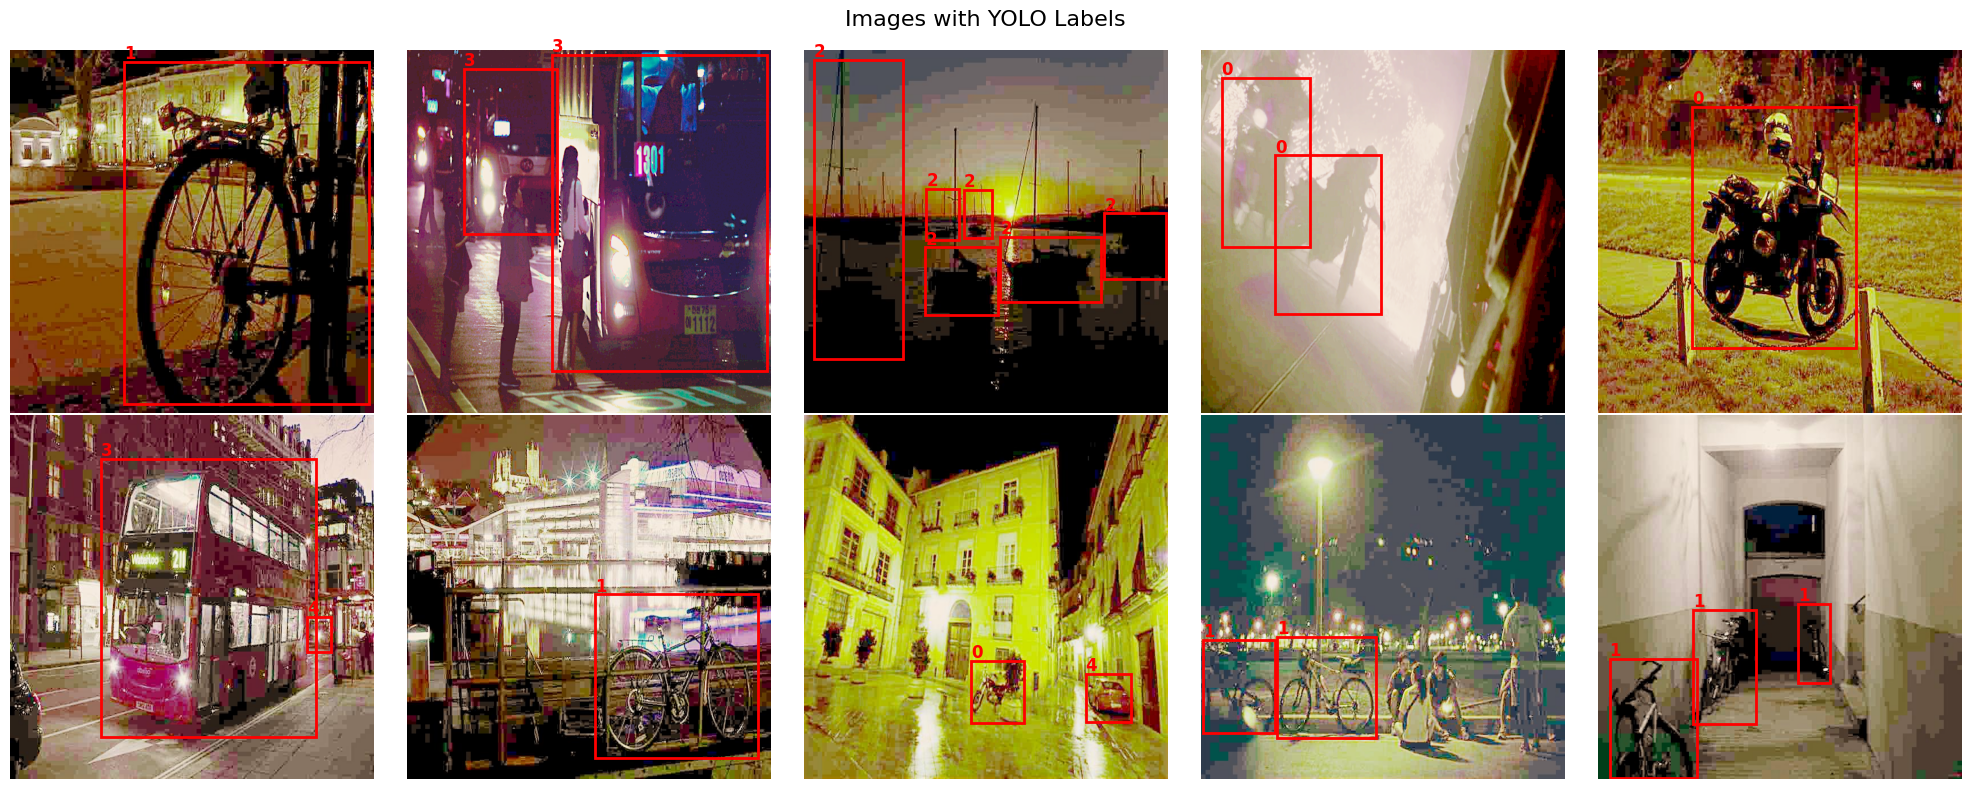

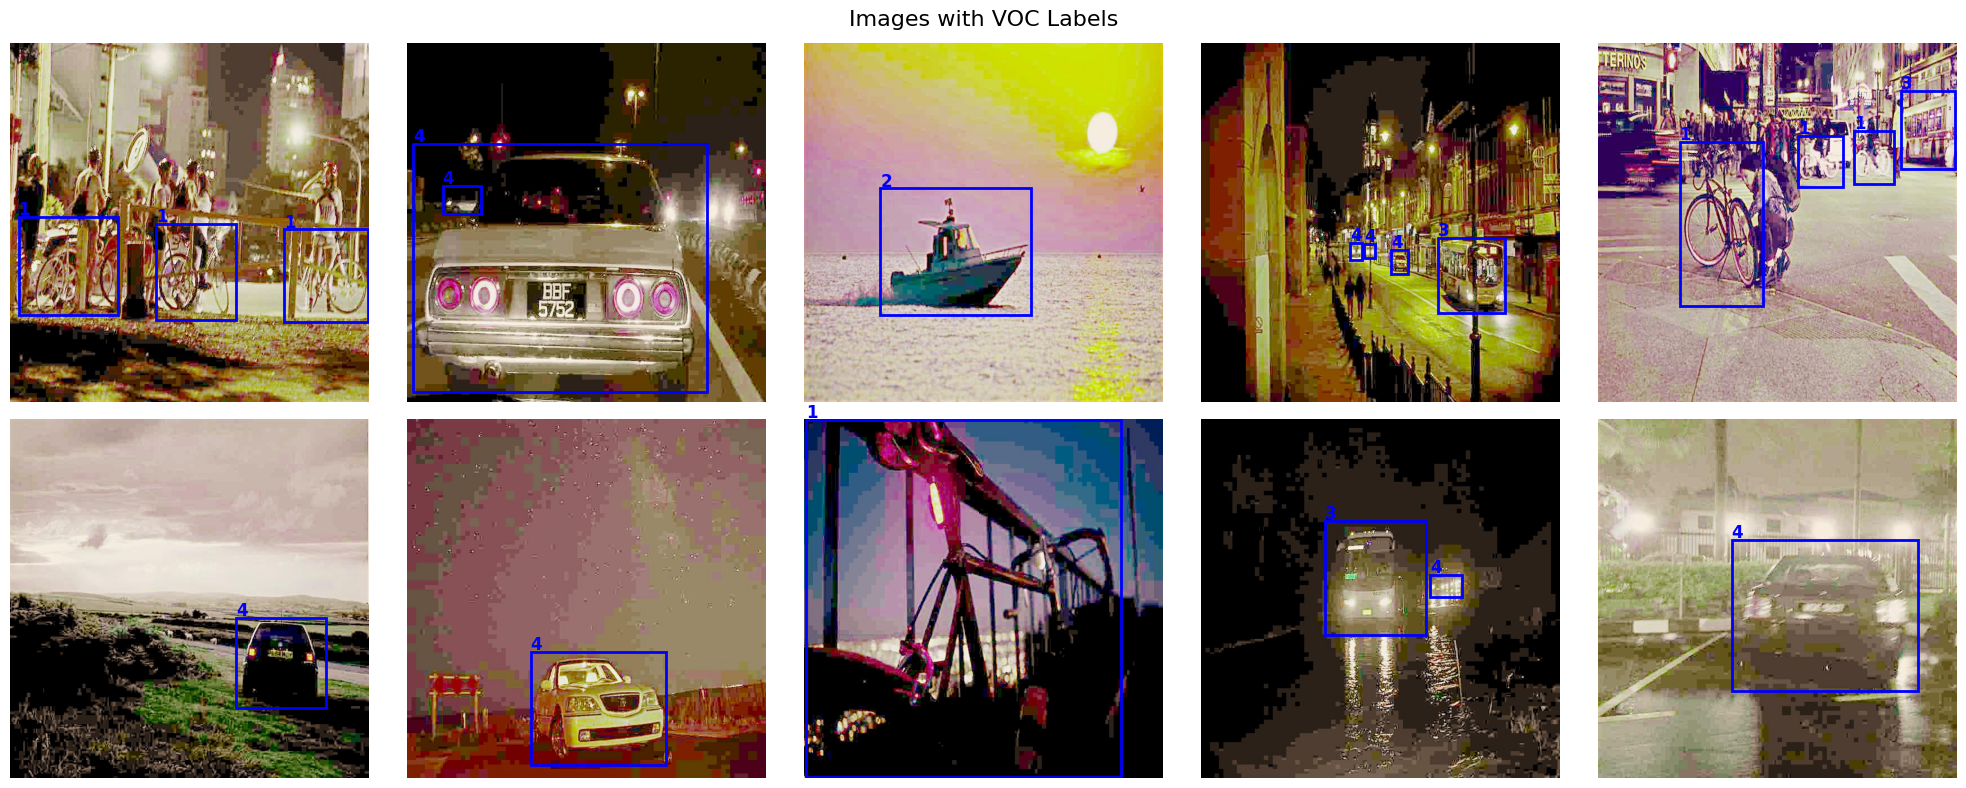

In [10]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image
import xml.etree.ElementTree as ET


# Function to plot YOLO labels
def plot_yolo_labels(image_path, label_path, ax):
    """
    Plot an image with YOLO bounding box annotations.
    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the YOLO label file.
        ax (matplotlib.axes._subplots.AxesSubplot): Axis to plot the image.
    """
    image = Image.open(image_path)
    ax.imshow(image)
    width, height = image.size

    if os.path.exists(label_path):
        with open(label_path, 'r') as label_file:
            for line in label_file:
                parts = line.strip().split()
                class_id = parts[0]
                x_center = float(parts[1]) * width
                y_center = float(parts[2]) * height
                bbox_width = float(parts[3]) * width
                bbox_height = float(parts[4]) * height

                # Calculate bounding box coordinates
                xmin = x_center - bbox_width / 2
                ymin = y_center - bbox_height / 2
                rect = patches.Rectangle((xmin, ymin), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymin - 5, class_id, color='red', fontsize=12, weight='bold')
    ax.axis("off")


# Function to plot VOC labels
def plot_voc_labels(image_path, voc_path, ax):
    """
    Plot an image with VOC bounding box annotations.
    Args:
        image_path (str): Path to the image file.
        voc_path (str): Path to the VOC XML annotation file.
        ax (matplotlib.axes._subplots.AxesSubplot): Axis to plot the image.
    """
    image = Image.open(image_path)
    ax.imshow(image)
    width, height = image.size

    if os.path.exists(voc_path):
        tree = ET.parse(voc_path)
        root = tree.getroot()
        for obj in root.findall("object"):
            name = obj.find("name").text
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            # Draw bounding box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, name, color='blue', fontsize=12, weight='bold')
    ax.axis("off")


# Directories
image_dir = '/kaggle/working/enhance_dce/train/images'
yolo_label_dir = '/kaggle/working/enhance_dce/train/labels'
voc_label_dir = '/kaggle/working/enhance_dce/VOC_Annotations'

# Get random 10 images for YOLO
image_files = os.listdir(image_dir)
random_yolo_images = random.sample(image_files, 10)

# Plot YOLO labels
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Images with YOLO Labels", fontsize=16)
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(image_dir, random_yolo_images[i])
    label_path = os.path.join(yolo_label_dir, os.path.splitext(random_yolo_images[i])[0] + '.txt')
    plot_yolo_labels(image_path, label_path, ax)
plt.tight_layout()
plt.show()

# Get random 10 images for VOC
random_voc_images = random.sample(image_files, 10)

# Plot VOC labels
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Images with VOC Labels", fontsize=16)
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(image_dir, random_voc_images[i])
    voc_path = os.path.join(voc_label_dir, os.path.splitext(random_voc_images[i])[0] + '.xml')
    plot_voc_labels(image_path, voc_path, ax)
plt.tight_layout()
plt.show()


In [11]:
!zip -r /kaggle/working/enhance_dce.zip /kaggle/working/enhance_dce

  adding: kaggle/working/enhance_dce/ (stored 0%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/ (stored 0%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2015_00484.xml (deflated 51%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2015_02854.xml (deflated 51%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2015_00609.xml (deflated 51%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2015_00297.xml (deflated 61%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2015_00030.xml (deflated 51%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2015_01151.xml (deflated 51%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2015_06081.xml (deflated 51%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2015_01257.xml (deflated 51%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2015_01071.xml (deflated 51%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2015_02246.xml (deflated 76%)
  adding: kaggle/working/enhance_dce/VOC_Annotations/2

In [12]:

from IPython.display import FileLink

# Create a download link
FileLink('/kaggle/working/enhance.zip')


/kaggle/working/enhance.zip

In [13]:
'''
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

def load_data(img_path):
  """Loads an image and optionally resizes it.

  Args:
    img_path: The path to the image file.
    resize: A boolean indicating whether to resize the image.

  Returns:
    The loaded image as a NumPy array. Returns None if the image cannot be loaded.
  """
  img = cv2.imread(img_path)
  img = cv2.resize(img, (640, 640))
  return img

# Tính SSIM và PSNR giữa 2 ảnh
def calculate_metrics(original_image, enhanced_image):
    # Explicitly set channel_axis to 2 for RGB images
    ssim_value = ssim(original_image, enhanced_image, channel_axis=2)  
    psnr_value = psnr(original_image, enhanced_image)
    return ssim_value, psnr_value

# Đường dẫn đến các thư mục của dữ liệu gốc và dữ liệu tăng cường
original_data_dir = '/kaggle/input/exdark-yolo-labels/test/images'
enhanced_data_dir = '/kaggle/working/enhance/test/images'

# Duyệt qua các ảnh trong thư mục dữ liệu gốc và dữ liệu tăng cường
ssim_list = []
psnr_list = []

# Giả sử rằng tên tệp của ảnh gốc và ảnh tăng cường giống nhau
for filename in os.listdir(original_data_dir):
    if filename.endswith(".jpg"):  # Chỉ tính các ảnh .jpg
        original_image_path = os.path.join(original_data_dir, filename)
        enhanced_image_path = os.path.join(enhanced_data_dir, filename)
        
        # Load ảnh gốc và ảnh tăng cường
        original_image  =load_data(original_image_path)
        enhanced_image  = load_data(enhanced_image_path)
        # Tính SSIM và PSNR
        ssim_value, psnr_value = calculate_metrics(original_image, enhanced_image)
        
        # Lưu lại kết quả
        ssim_list.append(ssim_value)
        psnr_list.append(psnr_value)

        # In kết quả từng ảnh (nếu cần)
        print(f"File: {filename} - SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.4f}")

# Tính giá trị trung bình của SSIM và PSNR
average_ssim = np.mean(ssim_list)
average_psnr = np.mean(psnr_list)

print(f"\nAverage SSIM: {average_ssim:.4f}")
print(f"Average PSNR: {average_psnr:.4f}")
'''

'\nimport os\nimport cv2\nimport numpy as np\nfrom skimage.metrics import structural_similarity as ssim\nfrom skimage.metrics import peak_signal_noise_ratio as psnr\nimport matplotlib.pyplot as plt\n\ndef load_data(img_path):\n  """Loads an image and optionally resizes it.\n\n  Args:\n    img_path: The path to the image file.\n    resize: A boolean indicating whether to resize the image.\n\n  Returns:\n    The loaded image as a NumPy array. Returns None if the image cannot be loaded.\n  """\n  img = cv2.imread(img_path)\n  img = cv2.resize(img, (640, 640))\n  return img\n\n# Tính SSIM và PSNR giữa 2 ảnh\ndef calculate_metrics(original_image, enhanced_image):\n    # Explicitly set channel_axis to 2 for RGB images\n    ssim_value = ssim(original_image, enhanced_image, channel_axis=2)  \n    psnr_value = psnr(original_image, enhanced_image)\n    return ssim_value, psnr_value\n\n# Đường dẫn đến các thư mục của dữ liệu gốc và dữ liệu tăng cường\noriginal_data_dir = \'/kaggle/input/exdark-yo